In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Defining class names
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot',
]

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader , random_split

data_dir = "/kaggle/working/fashionmnist"

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Seed for reproducibility
torch.manual_seed(7) #makes the training process reproducible

# Create training ,test and  validation datasets
trainset = datasets.FashionMNIST(data_dir, download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(data_dir, download=True, train=False, transform=transform)


total_size = len(trainset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

trainset, validset, testset = random_split(trainset, [train_size, val_size, test_size])

# Create data loaders for our datasets
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validloader = DataLoader(validset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('testing set has {} instances'.format(len(testset)))
print('Validation set has {} instances'.format(len(validset)))

Training set has 48000 instances
testing set has 6000 instances
Validation set has 6000 instances


In [ ]:
def extract_images_labels(loader):
    images = []
    labels = []
    for batch in loader:
        b_images, b_labels = batch
        images.append(b_images)
        labels.append(b_labels)
    return torch.cat(images, dim=0), torch.cat(labels, dim=0)

# Extracting train and test images and labels
train_images, train_labels = extract_images_labels(trainloader)
valid_images, valid_labels = extract_images_labels(validloader)
valtest_images, test_labels = extract_images_labels(testloader)

In [ ]:
train_images.shape


torch.Size([48000, 1, 28, 28])

In [ ]:
train_images.dim()


4

In [ ]:
len(train_labels)


48000

In [ ]:
valid_images.shape

torch.Size([6000, 1, 28, 28])

In [ ]:
len(valid_labels)


6000

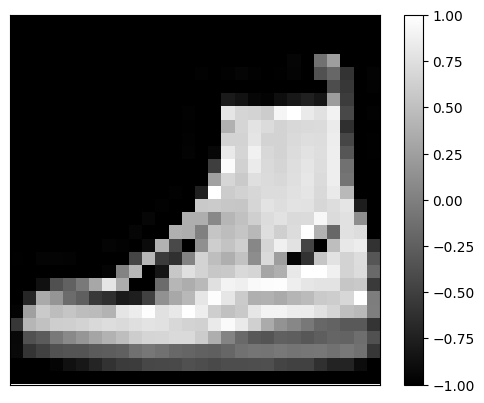

In [ ]:
# Plotting firt image
plt.figure()
plt.imshow(train_images[0][0], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

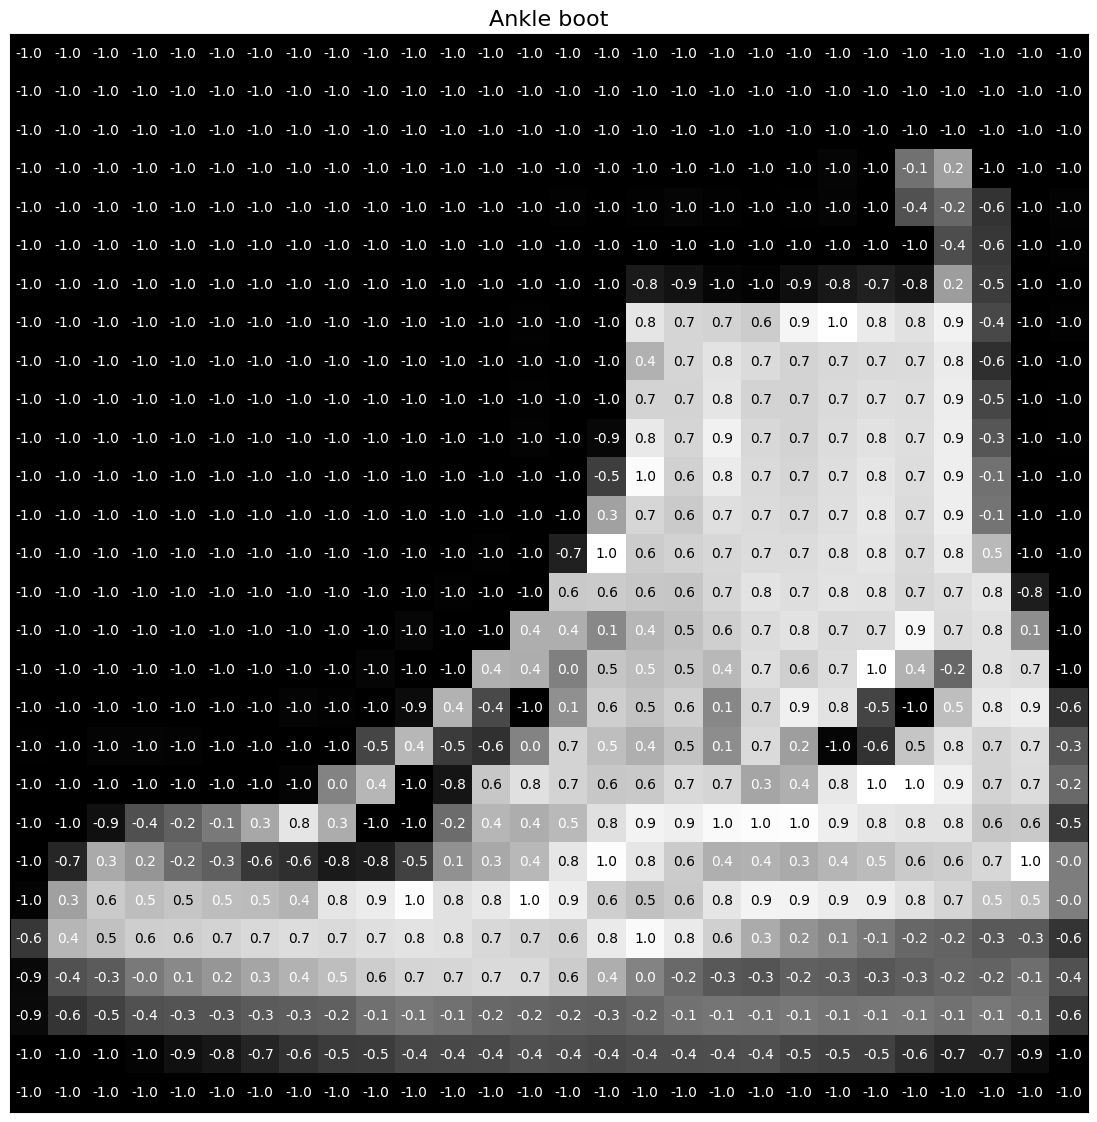

In [ ]:
def get_text_color(value:float) -> str:
    """Returns 'white' for dark pixels and 'black' for light pixels."""
    return 'white' if value < 0.5 else 'black'

image_numpy = train_images[0][0].squeeze().numpy()
label = train_labels[0]

# Plotting the image
plt.figure(figsize=(14,14))
plt.imshow(image_numpy, cmap='gray')
plt.title(class_names[label], fontsize=16,)
plt.grid(False)
plt.xticks([])
plt.yticks([])

# Overlaying the pixel values
for i in range(image_numpy.shape[0]):
    for j in range(image_numpy.shape[1]):
        plt.text(j, i, '{:.1f}'.format(image_numpy[i,j]), ha='center', va='center', color=get_text_color(image_numpy[i,j]))
plt.show()

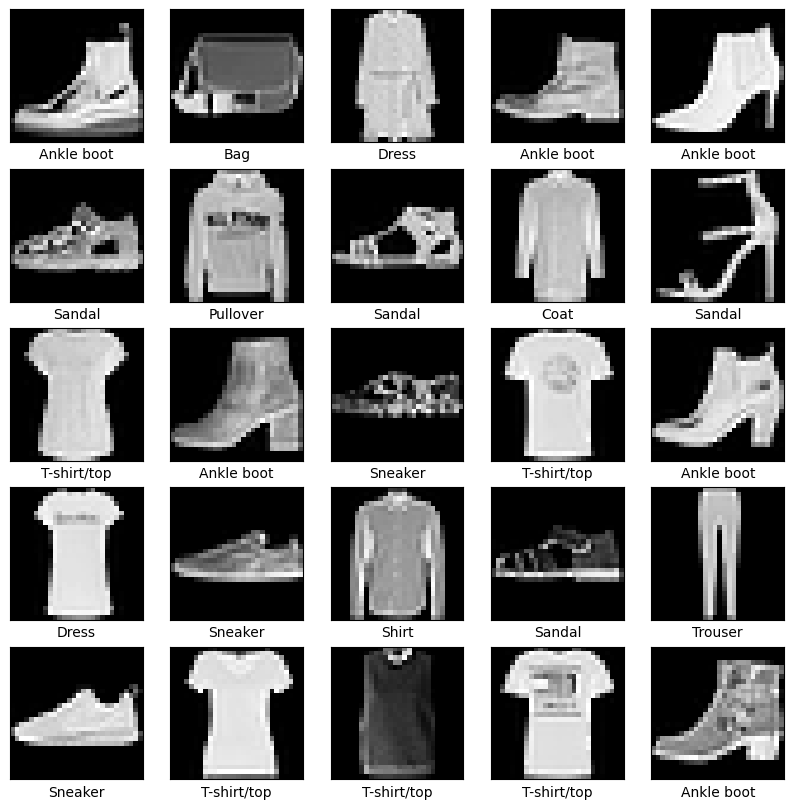

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][0], cmap='gray')
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Convolutional layers using Sequential
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),   # 32 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(inplace=True),                                  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 2x2 Max pooling with stride 2

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(inplace=True),                                  # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 2x2 Max pooling with stride 2
        )
        # Fully connected layers using Sequential
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                           # Flatten the output of conv layers
            nn.Linear(64 * 7 * 7, 128),                             # Fully connected layer with 128 neurons
            nn.ReLU(inplace=True),                                  # ReLU activation
            nn.Linear(128, 10)                                      # Output layer with 10 neurons for 10 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)                                     # Pass through conv layers
        x = self.fc_layers(x)                                       # Pass through fully connected layers
        return x

# Create the model instance
model = CNNClassifier()

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.2%}")


Accuracy on the test set: 91.65%


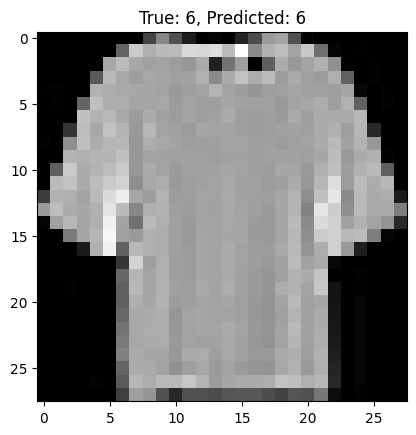

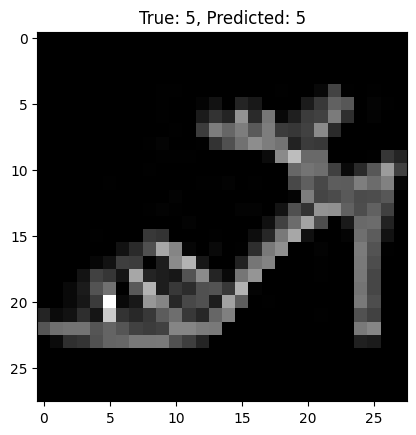

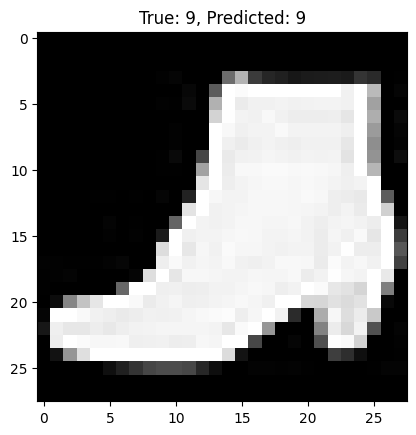

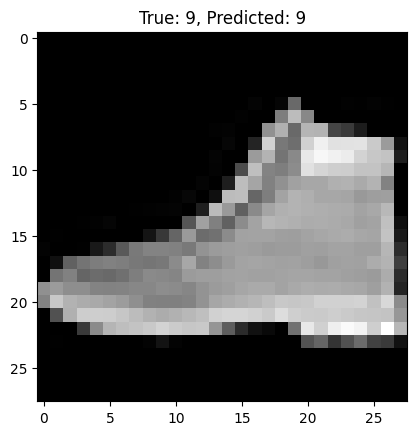

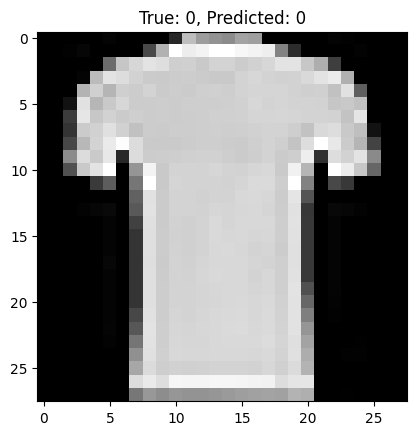

In [ ]:
for i in range(5):
    plt.imshow(images[i][0].cpu(), cmap='gray')
    plt.title(f"True: {labels[i]}, Predicted: {predicted[i]}")
    plt.show()